# HOMSTRAD Benchmark

In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [3]:
working_dir = '.'
results_path = os.path.join(working_dir,'results')
alignments_path = os.path.join(working_dir,'results/eba_ProstT5.pickle')
alignments_plain_path = os.path.join(working_dir,'results/eba_plain_ProstT5.pickle')
sequences_path = os.path.join(working_dir,'data/sequences.fasta')
homstrad_aln_path = os.path.join(working_dir,'data/homstrad_alignments.txt')

Load sequences

In [4]:
sequences = dict()
with open(sequences_path, 'r') as handle:
    for line in handle:
        if line[0]=='>':
            seq_id = line[1:].strip()
            sequences[seq_id]=''
        else:
            sequences[seq_id]+=line.strip()

Load alignments

In [5]:
results = dict()
for file in os.listdir(results_path):
    aln_path = os.path.join(results_path,file)
    with open(aln_path, 'rb') as handle:
        results[file.split('.pickle')[0]] = pickle.load(handle)

In [6]:
def get_aln_seq(pair,idx,EBA_alg):
    ''' 
        Converts EBA output in the desired alignment format.
    '''
    aln_seq = ''
    aln_number = idx+1
    for x in EBA_alg[pair]['aln_{}'.format(aln_number)]:
        if x!=-1:
            aln_seq+=sequences[pair[idx]][x]
        else:
            aln_seq+='-'
    
    return aln_seq

Convert EBA alignments in the 'correct' format

In [7]:
alg_seqs= dict()
for k in results:
    alg_seqs[k]=dict()
    for pair in results[k]:
        alg_seqs[k][pair] = list()
        alg_seqs[k][pair].append(get_aln_seq(pair,0,results[k]))
        alg_seqs[k][pair].append(get_aln_seq(pair,1,results[k]))

# Compare with Fooldseek results

In [8]:
def pairs_from_aln(start1, aln1, start2, aln2):
    i1, i2 = start1, start2
    pairs = []
    for letter1, letter2 in zip(aln1, aln2):
        if letter1 not in ('-', '/') and letter2 not in ('-', '/'):
            pairs.append((i1, i2))
        if letter1 not in ('-', '/'):
            i1 += 1
        if letter2 not in ('-', '/'):
            i2 += 1
    return pairs

In [9]:
def parse_EBA_ali(pair,alg_sequences):
    aln = {}
    if pair[0] != pair[1]:
        aln[(pair[0], pair[1])] = (1, alg_sequences[pair][0], 1, alg_sequences[pair][1])
    return aln

In [10]:
def get_homstrad_ali(path):
    alignments = dict()
    families = dict()
    read=False
    n_families = 0
    with open(path, 'r') as handle:
        for line in handle:
            if line[0]=='>':
                if read:
                    n_families+=1
                    alignments[pair_key].append((pair_key[0],seq1))
                    alignments[pair_key].append((pair_key[1],seq2))
                read=False
                if line.split()[3]=='HOMSTRAD':
                    seq1_id = line.split()[1]
                    seq2_id = line.split()[2]
                    pair_id = line.split()[0][1:]
                    pair_key = (pair_id+'_'+seq1_id,pair_id+'_'+seq2_id)
                    
                    if pair_key in alignments.keys():
                        print(pair_key)
                    
                    alignments[pair_key] = list()
                    ##is this the family??
                    families[pair_key] = line.split()[0][1:]
                    seq1 = ''
                    seq2 = ''
                    read=True
            
            elif read:
                if line=='\n':
                    continue
                current_id = line.split()[0]
                if current_id == seq1_id:
                    seq1+=line.split()[2]
                if current_id == seq2_id:
                    seq2+=line.split()[2]
    
    print('number of families: {}'.format(n_families))
    return alignments,families

Modified foldseek code

In [11]:
def check_alignment(pair,alg_sequences,family):
    aln = parse_EBA_ali(pair,alg_sequences)
    #print(aln)
    ref_aln = homstrad_ali[pair]
    
    res = []
    log = ''
    
    name1, ref_aln1 = ref_aln[0]
    name2, ref_aln2 = ref_aln[-1]
    
    if (name1, name2) not in aln:
        res.append([name1, name2, None, None, family, None])
        return res
    start1, aln1, start2, aln2 = predicted_aln = aln[(name1, name2)]

    ref_pairs = pairs_from_aln(0, ref_aln1, 0, ref_aln2)  # here
    pairs = pairs_from_aln(start1, aln1, start2, aln2)

    sensitivity = len([p for p in ref_pairs if p in pairs]) / len(ref_pairs)
    accuracy = len([p for p in pairs if p in ref_pairs]) / len(pairs)

    res.append([name1, name2, sensitivity, accuracy, family, predicted_aln])

    # Logging
    correct_pairs = [p for p in pairs if p in ref_pairs]
    correct_pos1 = {p[0] for p in correct_pairs}
    correct_pos2 = {p[1] for p in correct_pairs}
    refaln_pos1 = [p[0] for p in ref_pairs]
    refaln_pos2 = [p[1] for p in ref_pairs]
    seq1, between, seq2 = '', '', ''
    assert len(aln1) == len(aln2)
    i = start1
    for letter in aln1:
        if letter not in ('-', '/'):
            if i in correct_pos1:
                seq1 += str(refaln_pos1.index(i) % 10)  # 'o'
            else:
                if i in refaln_pos1:
                    #seq1 += 'x'
                    seq1 += str(refaln_pos1.index(i) % 10)  # 'x'
                else:
                    seq1 += 'n'  # FP
            i += 1
        else:
            seq1 += '-'
    i = start2
    for letter in aln2:
        if letter not in ('-', '/'):
            if i in correct_pos2:
                #seq2 += 'o'
                seq2 += str(refaln_pos2.index(i) % 10)  # 'o'
                between += '|'
            else:                        
                between += ' '
                if i in refaln_pos2:
                    seq2 += str(refaln_pos2.index(i) % 10)  # 'x'
                else:
                    seq2 += 'n'  # FP
            i += 1
        else:
            seq2 += '-'
            between += ' '

    log += f'> {name1} - {name2} (sensitivity: {sensitivity:.2f}, precision: {accuracy:.2f})\n\n'
    for i in range((len(aln1) + 99) // 100):
        log += seq1[i*100:(i+1)*100] + '\n' + between[i*100:(i+1)*100] + '\n' + seq2[i*100:(i+1)*100] + '\n\n'

    log += '*' * 100 + '\n\n'
            
    return res


In [12]:
def stats(res):
    found_ration = len([r for r in res if r[2] is not None]) / len(res)
    sensitivity = np.mean([r[2] or 0 for r in res])
    precision = np.mean([r[3] for r in res if r[3] is not None])
    return found_ration, sensitivity, precision

Get ground truth alignments

In [13]:
homstrad_ali, families = get_homstrad_ali(homstrad_aln_path)

number of families: 1032


Compute EBA sensitivity and precision

In [14]:
all_results = dict()
for k in alg_seqs:
    res = []
    print(k)
    for p in homstrad_ali:
        if p not in alg_seqs[k].keys():
            print(p)
            continue
        res+=check_alignment(p,alg_seqs[k],families[p])

    pa = stats(res)
    all_results[k] = (pa[1],pa[2])
    print(stats(res))

eba_ProstT5
(1.0, 0.8591711360494412, 0.8607224222719567)
eba_plain_ProstT5
(1.0, 0.7891575016399616, 0.831989985219545)


# Plot

Hardcode results from Foldseek notebook

In [15]:
all_results = dict()
all_results['DALI'] = (0.858, 0.913)
all_results['Foldseek'] = (0.833, 0.868)
all_results['Foldseek-TM'] = (0.872,0.885)
all_results['TMalign'] = (0.877,0.890)
all_results['CLE-SW'] = (0.759, 0.794)
all_results['MMseqs2'] = (0.325, 0.597)
all_results['EBA'] = (0.859, 0.861)
all_results['EBA-plain'] = (0.789, 0.832)

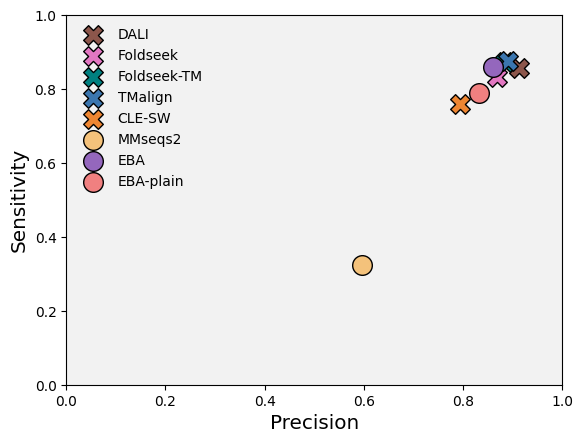

Name     	Sensitvity	Precision
----------------------------------------
DALI      	0.858		0.913
TMalign   	0.877		0.890
Foldseek-TM	0.872		0.885
Foldseek  	0.833		0.868
EBA       	0.859		0.861
EBA-plain 	0.789		0.832
CLE-SW    	0.759		0.794
MMseqs2   	0.325		0.597


In [16]:
colors = {"DALI":"tab:brown","TMalign":"#3B76AF","Foldseek":"tab:pink",'Foldseek-TM':"teal","CLE-SW":"#EE8632",
          "MMseqs2":"#F4C27B", "EBA":"tab:purple", "EBA-plain":"lightcoral",  
          "EBA-cosine":"tab:blue","EBA-cosine-plain":"tab:blue", "plain_ProtT5_EBA_min_SCOPE":"tab:purple", 
          "ESMb1_EBA_min_SCOPE":"tab:blue", "plain_ESMb1_EBA_min_SCOPE":"tab:blue", 'ProstT5_AD_SCOPE':'firebrick'}

markers = {"DALI":"X","TMalign":"X","Foldseek":"X","CLE-SW":"X",'Foldseek-TM':"X",
          "MMseqs2":"o", "EBA":"o", "EBA-plain":"o",'EBA-cosine':"o",'EBA-cosine-plain':"o"}

size = [20 for i in range(8)]
lines = []
csv_lines = []

for name in all_results:
    sens = all_results[name][0]
    prec = all_results[name][1]
    lines.append(f'{name:<10}\t{sens:.3f}\t\t{prec:.3f}')
    plt.scatter([prec], [sens], label=name, color=colors[name],
                marker=markers[name],edgecolors="black", s=200)
# Plot
background_color = '#F2F2F2'
plt.gca().set_facecolor(background_color)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Sensitivity',fontsize="x-large")
plt.xlabel('Precision',fontsize="x-large")
plt.legend(frameon=False)
#plt.savefig(plots_path, dpi=400)
plt.show()

# Print
print('Name     \tSensitvity\tPrecision')
print('-' * 40)
print('\n'.join(sorted(lines, key=lambda x: x.split()[2], reverse=True)))

### Scatter plot

In [33]:
res = []
eba_key = 'eba_ProstT5'
for p in homstrad_ali:
    if p not in alg_seqs[eba_key].keys():
        print(p)
        continue
    res+=check_alignment(p,alg_seqs[eba_key],families[p])

In [35]:
def get_F1_score(p,r):
    return 2*p*r/(p+r)

In [36]:
def get_pr(path,method):
    pr = dict()
    n_families = 0
    with open(path, 'r') as handle:
        for line in handle:
            if line[0]=='>':
                try:
                    if line.split()[3]==method:
                        seq1_id = line.split()[1]
                        seq2_id = line.split()[2]
                        pair_id = line.split()[0][1:]
                        pair_key = (pair_id+'_'+seq1_id,pair_id+'_'+seq2_id)
                        pr[pair_key] = (float(line.split()[5]),float(line.split()[7]))
                except:
                    n_families+=1
    
    print('number of failed aln: {}'.format(n_families))
    return pr

In [37]:
pr_DALI = get_pr(homstrad_aln_path,'DALI')
pr_Foldseek = get_pr(homstrad_aln_path,'Foldseek')

number of failed aln: 35


### DALI comparison

In [39]:
F1_EBA = list()
F1_DALI = list()

for i in res:
    k = (i[0],i[1])
    try:
        F1_DALI.append(get_F1_score(pr_DALI[k][0],pr_DALI[k][1]))
        F1_EBA.append(get_F1_score(i[2],i[3]))
        
    except:
        #print(k, pr_DALI[k][0],pr_DALI[k][1])
        if k in pr_DALI.keys():
            print(k, pr_DALI[k])

('ARM_1iala', 'ARM_3bct') (0.0, 0.0)
('cbp_4cln', 'cbp_2sas') (0.0, 0.0)
('fusion_gly_1svfa', 'fusion_gly_1svfb') (0.0, 0.0)
('GP41_1df4a', 'GP41_1qcea') (0.0, 0.0)
('hexapep_1lxa', 'hexapep_3tdt') (0.0, 0.0)
('internalin_1d0ba', 'internalin_1a9na') (0.0, 0.0)
('LRR_2bnh', 'LRR_1yrga') (0.0, 0.0)
('SNAP-25_1kild', 'SNAP-25_1l4ad') (0.0, 0.0)
('TBCA_1qsda', 'TBCA_1h7ca') (0.0, 0.0)
('TPR_1a17', 'TPR_1ihga') (0.0, 0.0)
('trfl_1dsn', 'trfl_1ce2a') (0.0, 0.0)


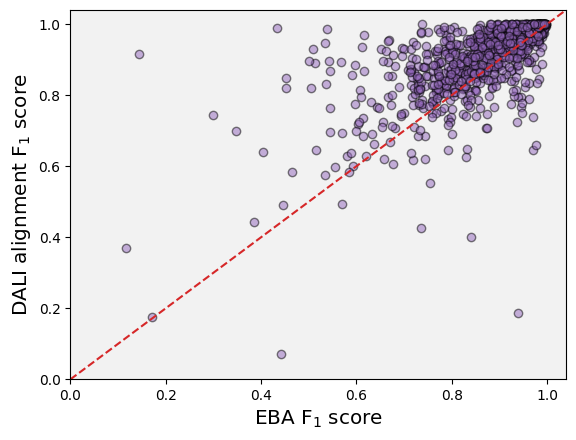

In [40]:
x = np.linspace(0, 1.04, 100)
y = x
plt.plot(x,y, '--', color='tab:red')
plt.xlim(0,1.04)
plt.ylim(0,1.04)
plt.xlabel('EBA F$_1$ score', fontsize="x-large")
plt.ylabel('DALI alignment F$_1$ score', fontsize="x-large")
plt.scatter(F1_EBA,F1_DALI,alpha=0.5,color='tab:purple',edgecolors="black")
background_color = '#F2F2F2'
plt.gca().set_facecolor(background_color)
#plt.savefig(plots_path, dpi=400)


### Foldseek comparison

In [41]:
F1_EBA = list()
F1_Foldseek = list()

for i in res:
    k = (i[0],i[1])
    try:
        F1_Foldseek.append(get_F1_score(pr_Foldseek[k][0],pr_Foldseek[k][1]))
        F1_EBA.append(get_F1_score(i[2],i[3]))
        
    except:
        if k in pr_Foldseek.keys():
            print(k, pr_Foldseek[k])

('Chorismate_mut_1ecma', 'Chorismate_mut_5csma') (0.0, 0.0)
('Cyclotide_1df6a', 'Cyclotide_1k48a') (0.0, 0.0)
('fusion_gly_1svfa', 'fusion_gly_1svfb') (0.0, 0.0)
('hexapep_1lxa', 'hexapep_3tdt') (0.0, 0.0)
('internalin_1d0ba', 'internalin_1a9na') (0.0, 0.0)
('LRR_2bnh', 'LRR_1yrga') (0.0, 0.0)
('PARATHYROID_1zwg', 'PARATHYROID_1bzg') (0.0, 0.0)
('prenyltrans_1ft1b', 'prenyltrans_2sqca') (0.0, 0.0)
('TPR_1a17', 'TPR_1ihga') (0.0, 0.0)
('VPR_1vpc', 'VPR_1ceua') (0.0, 0.0)


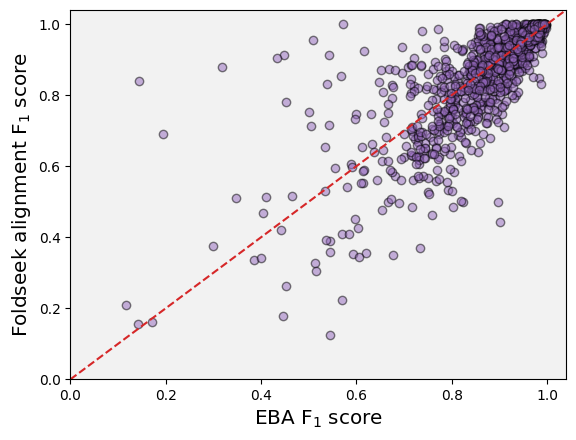

In [42]:
plt.plot(x,y, '--', color='tab:red')
plt.xlim(0,1.04)
plt.ylim(0,1.04)
plt.ylabel('Foldseek alignment F$_1$ score', fontsize="x-large")
plt.xlabel('EBA F$_1$ score', fontsize="x-large")
plt.scatter(F1_EBA,F1_Foldseek,alpha=0.5,color='tab:purple',edgecolors="black")
plt.gca().set_facecolor(background_color)
#plt.savefig(plots_path, dpi=400)